In [1]:
import numpy as np
import random
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import scatter, mask_to_index, index_to_mask, degree, to_networkx
from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
import torch.nn.functional as F
from torch import optim
from torch_scatter import scatter_sum, scatter_mean
import pickle
import matplotlib.pyplot as plt
import copy
from utils.infilling_util import trim_tree_to_binary, compute_kept_times, build_infill_tree, label_train_val_test_split
from models.model_infilling import TreeNodeClassifier, train_eval_classifier, eval_classifier
import math
from torch_geometric.utils import subgraph
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import h5py
from collections import defaultdict
import time

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

### Simple Warm-up task: merger node binary classification
Data: 
- pre-binarize: take the tree from full time scales, binarize it by keeping the most massive two ancesotors if there are $>2$ ancestors
- coarsen: drop the nodes from even time scales (i.e. ensure we retain the current time $t=1$, aka the root), and arrive at the coarsened tree. The dropped MERGER nodes are saved as in a dictionary $D = \{child(m): m\}$  where $child(m)$ stores the information of the child node of $[m]$ (i.e. the outgoing node).
- post-binarize: take the coarsened tree, binarize it again and  arrive at the tree $\cal{T}([n], E, X)$
- find merger nodes $M \subset [n]$
- add virtual nodes: for each merger node $n \in M$, add a virtual node $v(n)$ with 3 virtual edges flowing from $n$ and the ancestors of $n$; for each virtual node $v(n)$, label it as $1$ if $n \in D.keys()$, and otherwise zero. 

Task: Given T'([n]+M, E+3V', X), classify the virtual nodes

In [4]:

def visualize_trees(original_data, pruned_data, coarse_pruned_data, title):
    G_orig = to_networkx(original_data, to_undirected=False)
    G_pruned = to_networkx(pruned_data, to_undirected=False)
    G_coarse = to_networkx(coarse_pruned_data, to_undirected=False)

    pos_orig = graphviz_layout(G_orig, prog="dot")
    pos_pruned = graphviz_layout(G_pruned, prog="dot")
    pos_coarse = graphviz_layout(G_coarse, prog="dot")

    fig, axes = plt.subplots(1, 3, figsize=(20, 12), dpi=200)

    #node_colors = ["red" if original_data.node_halo_id[n].item() in original_data.mask_main else "skyblue" for n in G_orig.nodes()]
    #node_colors = ["red" if n in leaf_ids else "skyblue" for n in G_orig.nodes()]
    nx.draw(G_orig, pos=pos_orig, with_labels=False, arrows=True, arrowsize=1,
            ax=axes[0], node_color="skyblue", node_size=10)
    axes[0].set_title(f"Binary Tree (size={original_data.x.shape[0]})", fontsize=20)
    
    #prune_time = {i: f"{pruned_data.x[i,-1].item():.3f}" for i in range(pruned_data.x.shape[0])}
    nx.draw(G_pruned, pos=pos_pruned, with_labels=False, arrows=True,arrowsize=5,
            ax=axes[1], node_color='lightgreen', node_size=50)
    axes[1].set_title(f"Coarsen-Binary Tree (size={pruned_data.x.shape[0]})", fontsize=20)

    #coarse_time = {i: f"{coarse_pruned_data.x[i,-1].item():.3f}" for i in range(coarse_pruned_data.x.shape[0])}
    nx.draw(G_coarse, pos=pos_coarse, with_labels=False, arrows=True,arrowsize=5,
            ax=axes[2], node_color='orange', node_size=50)
    axes[2].set_title(f"Coarse Binary-Coarsen Tree (size={coarse_pruned_data.x.shape[0]})", fontsize=20)
    fig.suptitle(title)

    plt.savefig(f"Plots_trees/{original_data.root_halo_id}")
    plt.show()

In [5]:
def draw_infill_tree(infill_tree, node_size=10):
    G = to_networkx(infill_tree, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    #  Adjust red node positions
    new_pos = pos.copy()
    y_offset = 0.15  # How much higher to place the red nodes
    x_offset = 0.1
    num_nodes = infill_tree.x.shape[0]
    child_nodes = infill_tree.edge_index[0]
    parent_nodes = infill_tree.edge_index[1]
    virtual_nodes = torch.arange(num_nodes)[infill_tree.vn_mask].tolist()
    for red_node in virtual_nodes:
        #print(red_node)
        neighbors = child_nodes[parent_nodes == red_node]
        ancestors_id = torch.topk(infill_tree.x[neighbors,-1], 2, largest=False)[1].tolist()
        neighbors = neighbors[ancestors_id].tolist()
        #print(neighbors)
        x1, y1 = pos[neighbors[0]]
        x2, y2 = pos[neighbors[1]]
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        new_pos[red_node] = (mid_x + x_offset, mid_y + y_offset)

    fig, ax = plt.subplots(figsize=(16, 12), dpi=150)

    node_colors = ["red" if n in virtual_nodes else "skyblue" for n in G.nodes()]
    labels = {}
    for vn in virtual_nodes:
        labels[vn] = int(infill_tree.label[vn].item())
    #node_colors = ["red" if n in leaf_ids else "skyblue" for n in G_orig.nodes()]
    nx.draw(G, pos=new_pos, with_labels=False, arrows=True, arrowsize=3,
            ax=ax, node_color=node_colors, node_size=node_size)    
    nx.draw_networkx_labels(G, pos=new_pos, labels=labels)
    plt.show()


In [2]:
prune_trim_dataset= pickle.load(open(f"/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small/pruned_trimmed_trainset_n=3_lh=600.pkl","rb"))
sizes = np.array([data.x.shape[0] for data in prune_trim_dataset])
lhs = np.array([data.lh_id for data in prune_trim_dataset])
idx_max = np.argmax(sizes)
kept_times = compute_kept_times(prune_trim_dataset[idx_max])
print(kept_times)

tensor([1.0000, 0.9772, 0.9549, 0.9325, 0.9096, 0.8888, 0.8675, 0.8462, 0.8254,
        0.8046, 0.7839, 0.7638, 0.7437, 0.7237, 0.7038, 0.6843, 0.6669, 0.6455,
        0.6263, 0.6070, 0.5885, 0.5687, 0.5498, 0.5306, 0.5118, 0.4924, 0.4733,
        0.4541, 0.4346, 0.4147, 0.3951, 0.3748, 0.3543, 0.3335, 0.3121, 0.2903,
        0.2679, 0.2501, 0.2227, 0.2002, 0.1847, 0.1668, 0.1535, 0.1430, 0.1252,
        0.1164, 0.1058, 0.0967])


pruning to binary tree...with 40 nodes
original size = 3213, binary size = 2062
pruning to binary tree...with 23 nodes
original size = 1160, binary size = 945
found 102 merger nodes out of 945 nodes
features x = tensor([3.4366, 0.5274, 2.8884, 1.0000])
finish constructing the infill tree with 1047 nodes, 1250 edges!


/tmp/ipykernel_692151/3015065612.py:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


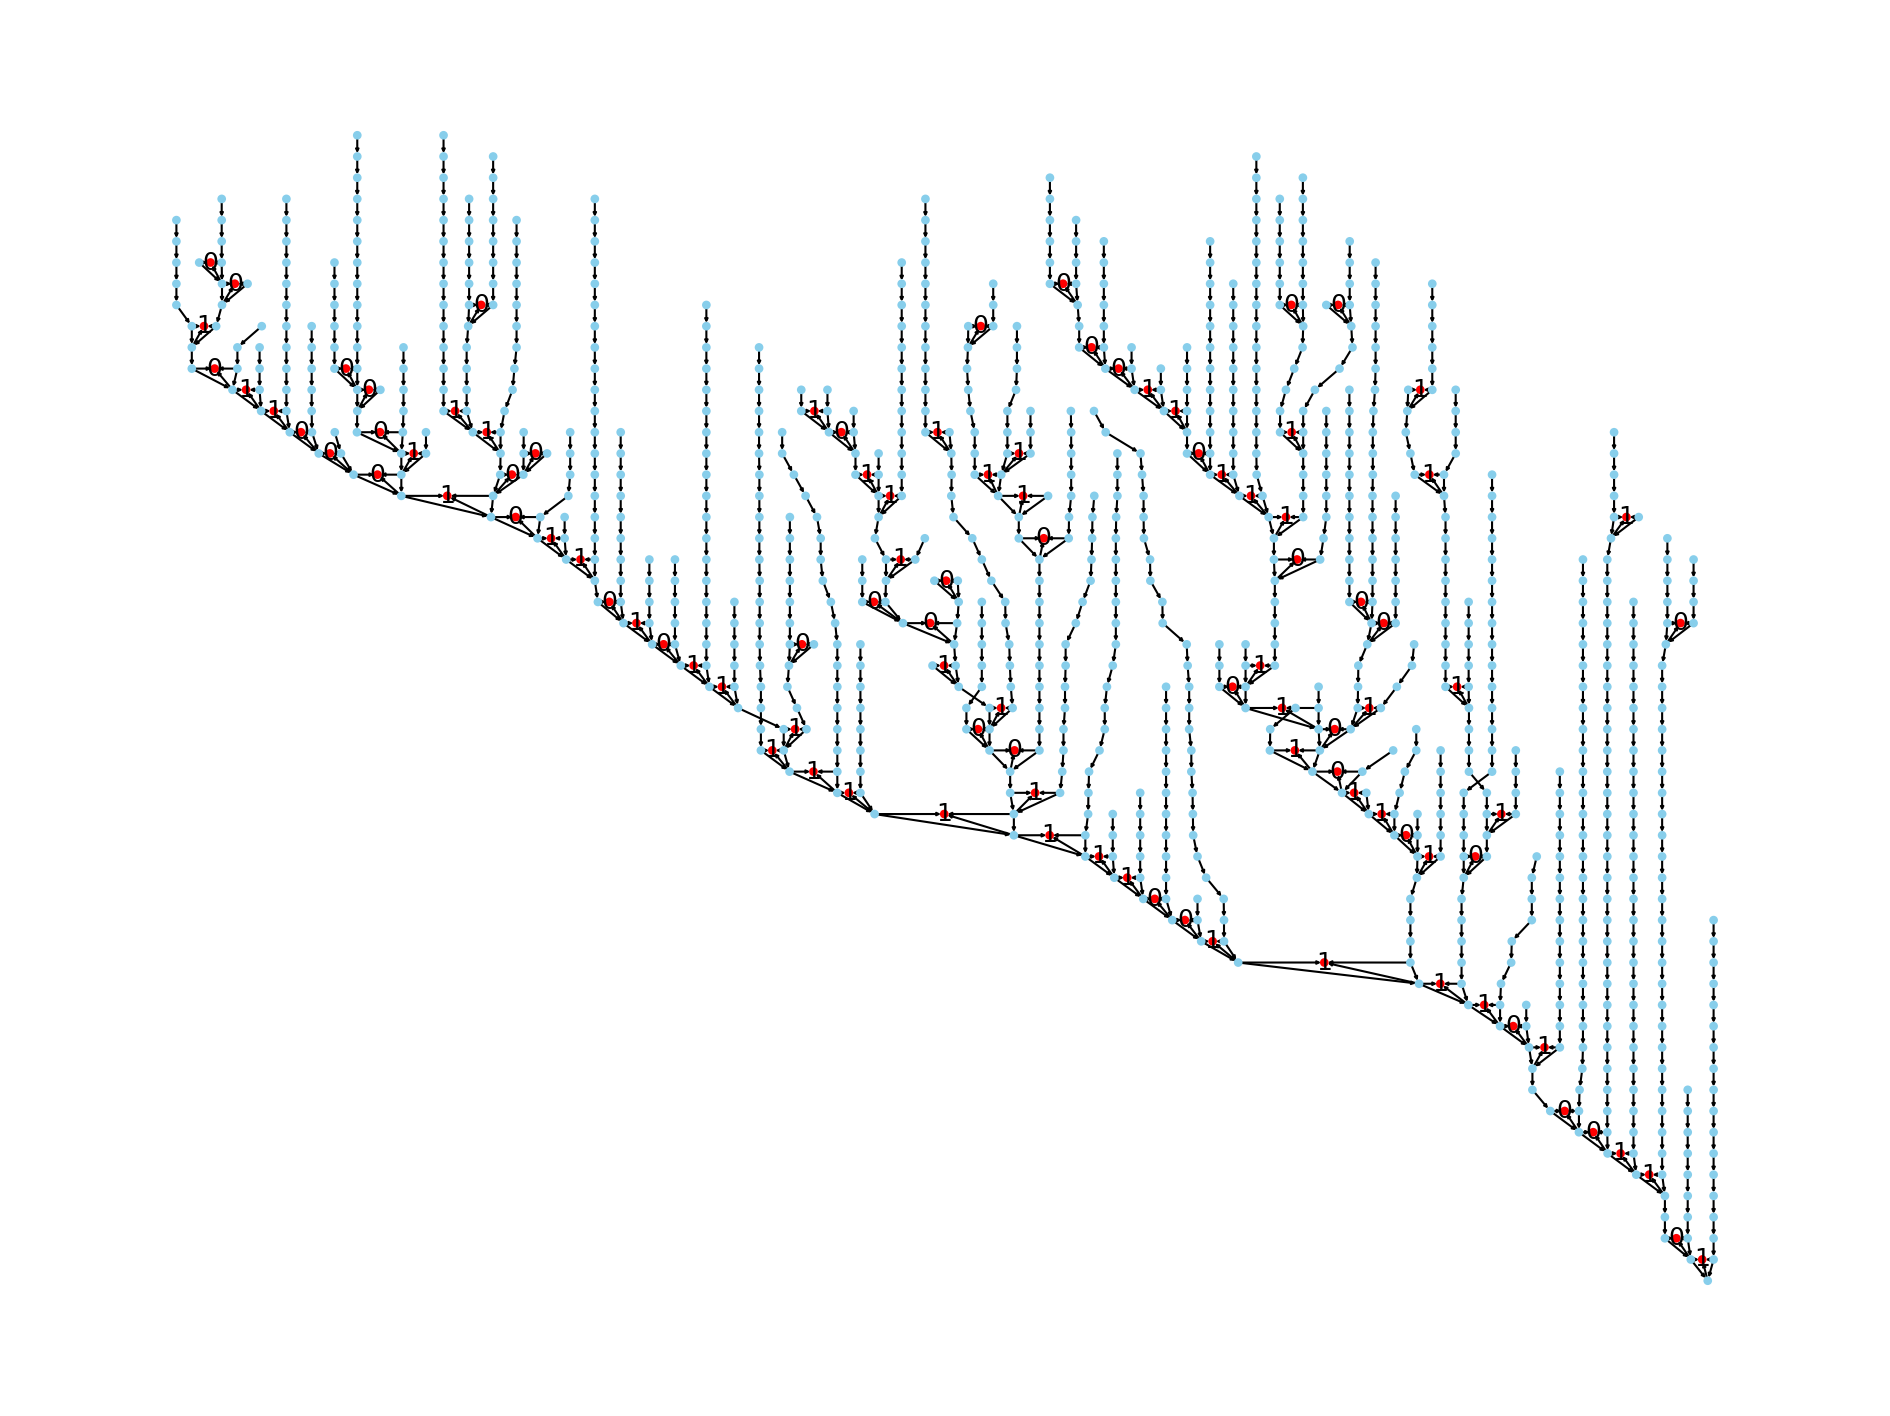

In [6]:
small = 0 #np.argmin(sizes)
data = prune_trim_dataset[small]
infill_tree = build_infill_tree(data, kept_times, verbose=True)
draw_infill_tree(infill_tree)

In [9]:
(infill_tree.label == 1).sum(), (infill_tree.label == 0).sum()

(tensor(57), tensor(45))

In [ ]:
#data processing
num_trees = 100
tree_ids = np.argsort(sizes)[-num_trees:]
all_trees = []
all_merger_ratios = []
for id in tree_ids:
    print(f"processing id={id}")
    data = prune_trim_dataset[id]
    infill_tree = build_infill_tree(data, kept_times, verbose=False)
    input_tree, ratio = label_train_val_test_split(infill_tree, seed=0)
    all_trees.append(input_tree)
    all_merger_ratios.append(ratio)
# data = prune_trim_dataset[idx_max]
# binary_tree = trim_tree_to_binary(data)
path = "/mnt/home/thuang/playground/datasets/pruned_trimmed_tree_small"
pickle.dump(all_trees, open(f"{path}/infilling_trees.pkl", "wb"))
pickle.dump(np.array(all_merger_ratios), open(f"{path}/infilling_merger_ratios.pkl", "wb"))